 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F  # Functional

import pandas as pd
from tqdm import notebook

Скачаем обучающую и контрольную выборки.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

### Получим информацию о датасете

In [ ]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
testset.data.shape

torch.Size([10000, 28, 28])

In [ ]:
pd_trainset = pd.DataFrame(trainset.targets.numpy())

for i in range(10):
  print('Class ', i, ': ', (pd_trainset == i).sum())

Class  0 :  0    6000
dtype: int64
Class  1 :  0    6000
dtype: int64
Class  2 :  0    6000
dtype: int64
Class  3 :  0    6000
dtype: int64
Class  4 :  0    6000
dtype: int64
Class  5 :  0    6000
dtype: int64
Class  6 :  0    6000
dtype: int64
Class  7 :  0    6000
dtype: int64
Class  8 :  0    6000
dtype: int64
Class  9 :  0    6000
dtype: int64


In [ ]:
pd_testset = pd.DataFrame(testset.targets.numpy())
for i in range(10):
  print('Class ', i, ': ', (pd_testset == i).sum())

Class  0 :  0    1000
dtype: int64
Class  1 :  0    1000
dtype: int64
Class  2 :  0    1000
dtype: int64
Class  3 :  0    1000
dtype: int64
Class  4 :  0    1000
dtype: int64
Class  5 :  0    1000
dtype: int64
Class  6 :  0    1000
dtype: int64
Class  7 :  0    1000
dtype: int64
Class  8 :  0    1000
dtype: int64
Class  9 :  0    1000
dtype: int64


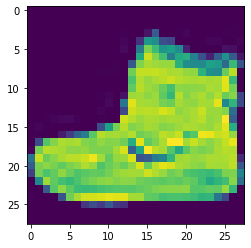

In [ ]:
plt.imshow(trainset.data[0])

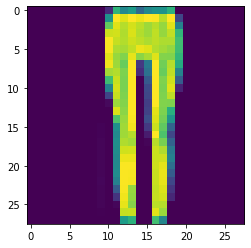

In [ ]:
plt.imshow(trainset.data[103])

### Многослойная нейронная сеть MLP

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
MLP_net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),  
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10)
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-3
optimizer = torch.optim.SGD(MLP_net.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
MLP_net.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
loss_history = []

for epoch in notebook.tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = MLP_net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        

        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            loss_history.append(running_loss / 2000)

            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено') 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        y_pred = MLP_net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('\nOverall cccuracy: ', (sum(class_correct) / sum(class_total)) * 100, '%')

Accuracy of T-shirt/top : 88 %
Accuracy of Trouser : 95 %
Accuracy of Pullover : 79 %
Accuracy of Dress : 88 %
Accuracy of  Coat : 77 %
Accuracy of Sandal : 95 %
Accuracy of Shirt : 54 %
Accuracy of Sneaker : 96 %
Accuracy of   Bag : 97 %
Accuracy of Ankle boot : 90 %

Overall cccuracy:  86.42 %


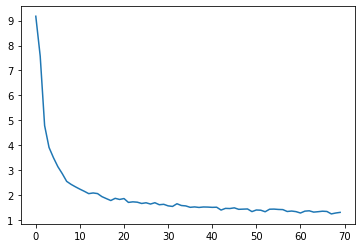

In [ ]:
plt.plot(loss_history, label='loss')

### Сверточная нейронная сеть

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(ConvNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        
        self.fc1 = nn.Linear(2 * 2 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.conv3(F.relu(self.conv2(x))))
        x = x.view(-1, 2 * 2 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# объявляем сеть
conv_net = ConvNet()
conv_net.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(conv_net.parameters(), lr=learning_rate)

In [ ]:
summary(conv_net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
            Conv2d-4             [-1, 32, 4, 4]          12,832
         MaxPool2d-5             [-1, 32, 2, 2]               0
            Linear-6                  [-1, 120]          15,480
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 41,898
Trainable params: 41,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.16
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [ ]:
# итерируемся
cnn_loss_history = []

for epoch in notebook.tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = conv_net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()


        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            cnn_loss_history.append(running_loss / 2000)

            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.236
[1,  4000] loss: 0.816
[1,  6000] loss: 0.751
[1,  8000] loss: 0.699
[1, 10000] loss: 0.671
[1, 12000] loss: 0.629
[1, 14000] loss: 0.602


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.610
[2,  4000] loss: 0.565
[2,  6000] loss: 0.545
[2,  8000] loss: 0.547
[2, 10000] loss: 0.545
[2, 12000] loss: 0.515
[2, 14000] loss: 0.495


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.481
[3,  4000] loss: 0.478
[3,  6000] loss: 0.466
[3,  8000] loss: 0.462
[3, 10000] loss: 0.439
[3, 12000] loss: 0.441
[3, 14000] loss: 0.438


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  2000] loss: 0.416
[4,  4000] loss: 0.400
[4,  6000] loss: 0.413
[4,  8000] loss: 0.415
[4, 10000] loss: 0.403
[4, 12000] loss: 0.391
[4, 14000] loss: 0.389


  0%|          | 0/15000 [00:00<?, ?it/s]

[5,  2000] loss: 0.380
[5,  4000] loss: 0.375
[5,  6000] loss: 0.367
[5,  8000] loss: 0.363
[5, 10000] loss: 0.368
[5, 12000] loss: 0.376
[5, 14000] loss: 0.371


  0%|          | 0/15000 [00:00<?, ?it/s]

[6,  2000] loss: 0.355
[6,  4000] loss: 0.344
[6,  6000] loss: 0.348
[6,  8000] loss: 0.324
[6, 10000] loss: 0.361
[6, 12000] loss: 0.338
[6, 14000] loss: 0.358


  0%|          | 0/15000 [00:00<?, ?it/s]

[7,  2000] loss: 0.342
[7,  4000] loss: 0.326
[7,  6000] loss: 0.316
[7,  8000] loss: 0.327
[7, 10000] loss: 0.324
[7, 12000] loss: 0.326
[7, 14000] loss: 0.333


  0%|          | 0/15000 [00:00<?, ?it/s]

[8,  2000] loss: 0.324
[8,  4000] loss: 0.315
[8,  6000] loss: 0.313
[8,  8000] loss: 0.301
[8, 10000] loss: 0.309
[8, 12000] loss: 0.311
[8, 14000] loss: 0.308


  0%|          | 0/15000 [00:00<?, ?it/s]

[9,  2000] loss: 0.306
[9,  4000] loss: 0.288
[9,  6000] loss: 0.301
[9,  8000] loss: 0.287
[9, 10000] loss: 0.301
[9, 12000] loss: 0.301
[9, 14000] loss: 0.296


  0%|          | 0/15000 [00:00<?, ?it/s]

[10,  2000] loss: 0.281
[10,  4000] loss: 0.276
[10,  6000] loss: 0.286
[10,  8000] loss: 0.283
[10, 10000] loss: 0.291
[10, 12000] loss: 0.279
[10, 14000] loss: 0.291
Обучение закончено


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        y_pred = conv_net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('\nOverall cccuracy: ', (sum(class_correct) / sum(class_total)) * 100, '%')

Accuracy of T-shirt/top : 75 %
Accuracy of Trouser : 96 %
Accuracy of Pullover : 71 %
Accuracy of Dress : 91 %
Accuracy of  Coat : 85 %
Accuracy of Sandal : 95 %
Accuracy of Shirt : 71 %
Accuracy of Sneaker : 95 %
Accuracy of   Bag : 97 %
Accuracy of Ankle boot : 95 %

Overall cccuracy:  87.67 %


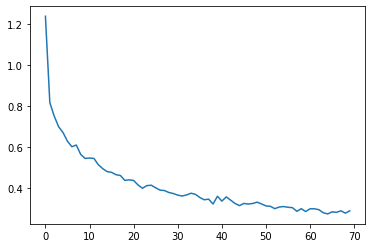

In [ ]:
plt.plot(cnn_loss_history, label='loss')

Вывод: Сверточная нейронная сеть требудет больше времени на обучение, однако показатели accuracy у нее лучше по сравнению с MLP.

Теперь давайте ради интереса и тренировки попробуем связку tensorflow-keras

In [ ]:
import tensorflow 
import os 
import numpy as np 
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.models import Sequential
from pickle import dump, load 
import datetime 
import matplotlib.pyplot as plt 
 
 
from tensorflow.keras import models 
from tensorflow.keras import layers 
from tensorflow.keras import optimizers 

In [ ]:
x_train=np.array(trainset.data)
x_test=np.array(testset.data)
y_train=np.array(trainset.targets)
y_test=np.array(testset.targets)

In [ ]:
print(x_train.shape,x_test.shape, y_train.shape,y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(32,input_shape=(28, 28, 1), kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               524416    
                                                      

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=1000, validation_split=0.2)

Epoch 1/10
48/48 [==============================] - 118s 2s/step - loss: 0.9441 - accuracy: 0.6783 - val_loss: 0.5163 - val_accuracy: 0.8190
Epoch 2/10
48/48 [==============================] - 112s 2s/step - loss: 0.4761 - accuracy: 0.8333 - val_loss: 0.3960 - val_accuracy: 0.8632
Epoch 3/10
48/48 [==============================] - 114s 2s/step - loss: 0.3921 - accuracy: 0.8617 - val_loss: 0.3459 - val_accuracy: 0.8767
Epoch 4/10
48/48 [==============================] - 114s 2s/step - loss: 0.3498 - accuracy: 0.8767 - val_loss: 0.3072 - val_accuracy: 0.8896
Epoch 5/10
48/48 [==============================] - 112s 2s/step - loss: 0.3216 - accuracy: 0.8850 - val_loss: 0.2943 - val_accuracy: 0.8936
Epoch 6/10
48/48 [==============================] - 113s 2s/step - loss: 0.3012 - accuracy: 0.8922 - val_loss: 0.2822 - val_accuracy: 0.8955
Epoch 7/10
48/48 [==============================] - 114s 2s/step - loss: 0.2861 - accuracy: 0.8967 - val_loss: 0.2678 - val_accuracy: 0.9033
Epoch 8/10
48

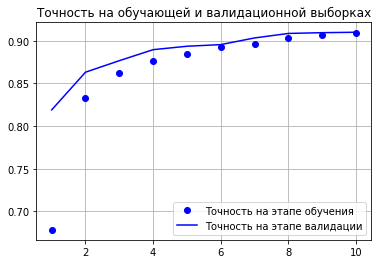

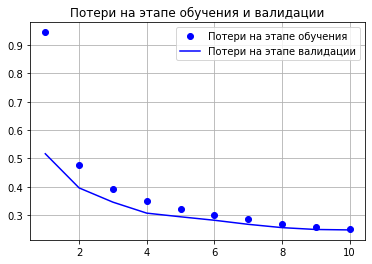

In [ ]:
accuracy = history.history["accuracy"] 
val_accuracy = history.history["val_accuracy"] 
loss = history.history["loss"] 
val_loss = history.history["val_loss"] 
epochs = range(1, len(accuracy) + 1) 
plt.plot(epochs, accuracy, "bo", label="Точность на этапе обучения") 
plt.plot(epochs, val_accuracy, "b", label="Точность на этапе валидации") 
plt.title("Точность на обучающей и валидационной выборках") 
plt.legend() 
plt.grid() 
plt.figure() 
plt.plot(epochs, loss, "bo", label="Потери на этапе обучения") 
plt.plot(epochs, val_loss, "b", label="Потери на этапе валидации") 
plt.title("Потери на этапе обучения и валидации") 
plt.legend() 
plt.grid() 
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 9s 28ms/step - loss: 0.2631 - accuracy: 0.9032


[0.26314324140548706, 0.9031999707221985]

Уже лучше, попробуем немного поменять параметры модели и попробовать еще раз.

In [ ]:
model2 = Sequential()

In [ ]:
model2.add(Conv2D(32,input_shape=(28, 28, 1), kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(10, activation='softmax'))

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 flatten_4 (Flatten)         (None, 4096)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                262208    
                                                      

In [ ]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(x_train, y_train, epochs=10, batch_size=1000, validation_split=0.2)

Epoch 1/10
48/48 [==============================] - 114s 2s/step - loss: 5.0537 - accuracy: 0.5766 - val_loss: 0.5504 - val_accuracy: 0.8014
Epoch 2/10
48/48 [==============================] - 113s 2s/step - loss: 0.5266 - accuracy: 0.8126 - val_loss: 0.4210 - val_accuracy: 0.8432
Epoch 3/10
48/48 [==============================] - 111s 2s/step - loss: 0.4353 - accuracy: 0.8438 - val_loss: 0.3776 - val_accuracy: 0.8616
Epoch 4/10
48/48 [==============================] - 113s 2s/step - loss: 0.3910 - accuracy: 0.8571 - val_loss: 0.3497 - val_accuracy: 0.8712
Epoch 5/10
48/48 [==============================] - 113s 2s/step - loss: 0.3572 - accuracy: 0.8699 - val_loss: 0.3362 - val_accuracy: 0.8764
Epoch 6/10
48/48 [==============================] - 111s 2s/step - loss: 0.3342 - accuracy: 0.8775 - val_loss: 0.3153 - val_accuracy: 0.8868
Epoch 7/10
48/48 [==============================] - 113s 2s/step - loss: 0.3182 - accuracy: 0.8850 - val_loss: 0.3150 - val_accuracy: 0.8827
Epoch 8/10
48

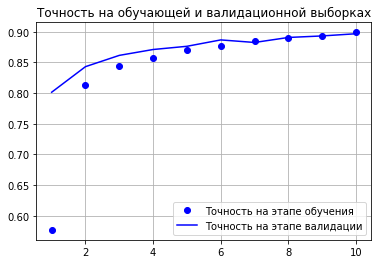

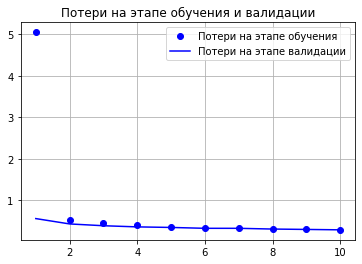

In [ ]:
accuracy = history2.history["accuracy"] 
val_accuracy = history2.history["val_accuracy"] 
loss = history2.history["loss"] 
val_loss = history2.history["val_loss"] 
epochs = range(1, len(accuracy) + 1) 
plt.plot(epochs, accuracy, "bo", label="Точность на этапе обучения") 
plt.plot(epochs, val_accuracy, "b", label="Точность на этапе валидации") 
plt.title("Точность на обучающей и валидационной выборках") 
plt.legend() 
plt.grid() 
plt.figure() 
plt.plot(epochs, loss, "bo", label="Потери на этапе обучения") 
plt.plot(epochs, val_loss, "b", label="Потери на этапе валидации") 
plt.title("Потери на этапе обучения и валидации") 
plt.legend() 
plt.grid() 
plt.show()

In [ ]:
model2.evaluate(x_test, y_test)

313/313 [==============================] - 7s 23ms/step - loss: 0.2913 - accuracy: 0.8953


[0.29127129912376404, 0.8952999711036682]

К сожалению, мы так и не смогли достичь - 91% accuracy на валидационной выборке, а это уже можно считать неплохим результатом. Также, мы использовали два фреймворка PyTorch и Tensorflow.